In [1]:
# 필요한 모듈 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')



In [2]:
# 시계열 데이터 가져오기
data_path = os.getenv("HOME") + '/aiffel/stock_prediction/data/AAPL_Month.csv'

# 원본 데이터 확인하기
df = pd.read_csv(data_path)
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-03-01,19.577499,22.194643,18.436428,21.412500,18.334970,15584338000
1,2012-04-01,21.493929,23.000000,19.821428,20.856428,17.858822,15598990400
2,2012-05-01,20.889286,21.312857,18.649286,20.633215,17.667692,11106345600
3,2012-06-01,20.327143,21.071428,19.589287,20.857143,17.859436,7855825600
4,2012-07-01,20.883215,22.138214,20.357143,21.812857,18.677780,8909650400


In [3]:
# 위 원본에서 종가만 사용한다
# Date 컬럼을 index로 삼아 시계열을 생성한다
df = pd.read_csv(data_path, index_col="Date", parse_dates=True)
ts = df['Close']

ts.head()

Date
2012-03-01    21.412500
2012-04-01    20.856428
2012-05-01    20.633215
2012-06-01    20.857143
2012-07-01    21.812857
Name: Close, dtype: float64

In [4]:
# 결측치 처리
ts = ts.interpolate(method='time') # 기준은 time으로 
ts[ts.isna()] # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

In [5]:
def plot_rolling_statistics(timeseries, window=15):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()   # 이동표준편차 시계열
    
    # 원본시계열, 이동평균, 이동표준편차 plot으로 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)


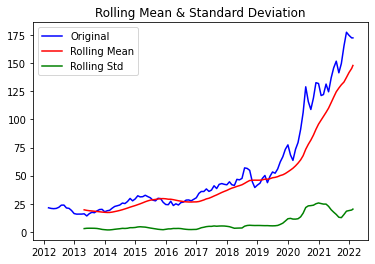

In [6]:
plot_rolling_statistics(ts)

In [7]:
# 로그 변환
ts_log = np.log(ts)

In [8]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드 호출
    dftest = adfuller(timeseries, autolag="AIC")
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print("Results of Dickey-Fuller Test:")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

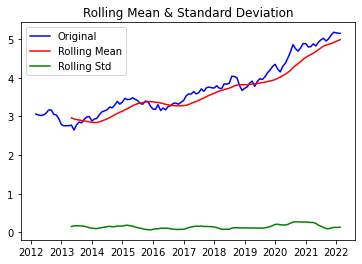

Results of Dickey-Fuller Test:
Test Statistic                   0.851899
p-value                          0.992429
#Lags Used                       0.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


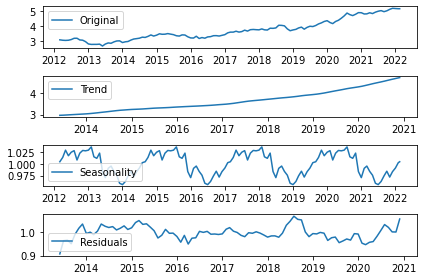

In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=15)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

`Residual` = `Original` 데이터에서 `Trend`, `Seasonality` 제거하고 난 나머지

In [10]:
# Residual 안정성 확인
residual.dropna(inplace=True) # 결측치 제거
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                 -4.136403
p-value                         0.000843
#Lags Used                      0.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


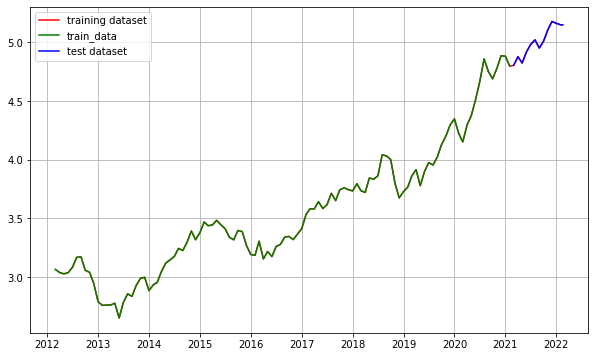

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(train_data, c='g', label='train_data')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

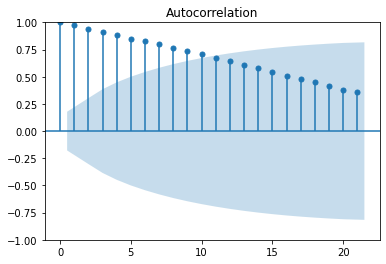

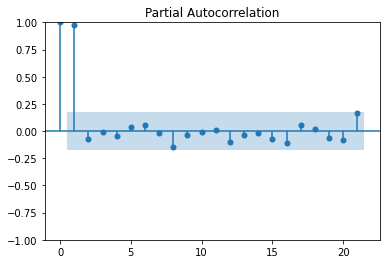

In [12]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -8.168424e+00
p-value                        8.754761e-13
#Lags Used                     1.000000e+00
Number of Observations Used    1.180000e+02
Critical Value (1%)           -3.487022e+00
Critical Value (5%)           -2.886363e+00
Critical Value (10%)          -2.580009e+00
dtype: float64


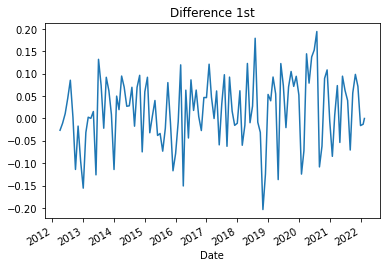

In [13]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [14]:
# # 필요할 때 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

In [15]:
# 모델 빌드하기
model = ARIMA(train_data, order=(30, 0, 1)) # order=c(p,d,q) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  108
Model:                ARIMA(30, 0, 1)   Log Likelihood                 131.304
Date:                Thu, 17 Feb 2022   AIC                           -196.608
Time:                        14:03:14   BIC                           -108.098
Sample:                    03-01-2012   HQIC                          -160.720
                         - 02-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7316      0.610      6.115      0.000       2.536       4.928
ar.L1          0.2171      1.913      0.113      0.910      -3.533       3.967
ar.L2          0.8277      2.058      0.402      0.6

In [16]:
# # 모델 훈련 결과 시각적으로 확인

# fitted_m = fitted_m.predict()
# fitted_m = fitted_m.drop(fitted_m.index[0])
# plt.figure(figsize=(20, 5))
# plt.plot(fitted_m, label='predict')
# plt.plot(train_data, label='train_data')
# plt.legend()

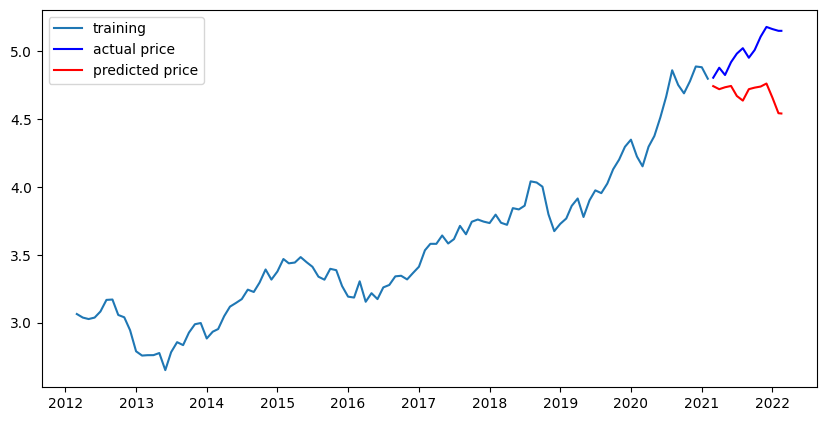

In [17]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [18]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2347.732119261363
MAE:  42.3567702845861
RMSE:  48.45340152415889
MAPE: 26.52%
